In [1]:
from datetime import datetime, timedelta
import pandas as pd
import pandas_bokeh

pandas_bokeh.output_notebook()
import numpy as np
import matplotlib.pyplot as plt
import cbpro

import os
from pathlib import Path
import seaborn as sns

sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)

sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

tf.distribute.OneDeviceStrategy(device="/gpu:0")
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.experimental.set_policy(policy)
np.set_printoptions(suppress=True)

public_client = cbpro.PublicClient()


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [2]:
class MinerMeta(type):
    def compile_historic(self, timestamp=False):
        file = Path.cwd() / f"{self.coin}_histdata.csv"
        if file:
            df = pd.read_csv(file, index_col="time", infer_datetime_format=True)
            return df
        else:
            start_date = datetime(2020, 1, 1)
            end_date = datetime.today()
            delta = timedelta(hours=300)
            df = pd.DataFrame()

        while start_date <= end_date:
            historic = public_client.get_product_historic_rates(
                f"{self.coin}-USD",
                granularity=3600,
                start=start_date,
                end=start_date + delta,
            )
            start_date += delta
            df = df.append(historic, ignore_index=True)
        df.columns = ["time", "low", "high", "open", "close", "volume"]
        date_time = pd.to_datetime(df["time"], unit="s")

        timestamp_s = date_time.map(pd.Timestamp.timestamp)
        day = 24 * 60 * 60
        year = (365.2425) * day
        df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
        df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
        df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
        df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
        df.reset_index(drop=True, inplace=True)

        if timestamp is True:
            pass
        else:
            df["time"] = pd.to_datetime(df["time"], unit="s")

        df.to_csv(file, index=False)

        return df

    def get_day_stats(self):
        result = getattr(self, "day_stats", None)
        if result is None:
            ticker = public_client.get_product_24hr_stats(f"{self.coin}-USD")
            df = pd.DataFrame.from_dict(ticker, orient="index")
            self.day_stats = df
        return df

    def year_day_fft(self, col):
        df = self.compile_historic()
        today = datetime.today()

        fft = tf.signal.rfft(df[col])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = 1
        hours_per_year = 24 * 365.2524
        years_per_dataset = n_samples_h / (hours_per_year)

        f_per_year = f_per_dataset / years_per_dataset
        plt.step(f_per_year, np.abs(fft))
        plt.xscale("log")
        plt.ylim(1000, 50000)
        plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 365.2524], labels=["1/Year", "1/day"])
        plt.xlabel("Frequency (log scale)")

        return plt.show()

    def ttsplit_norm(self, df, split_time=0.7, feature_plot=False):
        # train_df Test Split
        n = len(df)
        train_df = df[0 : int(n * 0.7)]
        val_df = df[int(n * 0.7) : int(n * 0.9)]
        test_df = df[int(n * 0.9) :]
        # Normalize the Data
        train_df_mean = train_df.mean()
        train_df_std = train_df.std()

        train_df = (train_df - train_df_mean) / train_df_std
        val_df = (val_df - train_df_mean) / train_df_std
        test_df = (test_df - train_df_mean) / train_df_std

        # Create Feature Plot if wanted
        if feature_plot is True:
            df_std = (df - train_df_mean) / train_df_std
            df_std = df_std.melt(var_name="Column", value_name="Normalized")
            plt.figure(figsize=(12, 6))
            ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
            ax.set_xticklabels(df.keys(), rotation=90)
            ax.set_title("train_dfing Data Feature Dist with whole DF Mean")

            return train_df, val_df, test_df

        return train_df, val_df, test_df

    def __call__(self, *args, **kwargs):

        cls = type.__call__(self, *args)

        # setattr(cls, "compile_historic", self.compile_historic)
        # setattr(cls, "year_day_fft", self.year_day_fft)
        # setattr(cls, "ttsplit_norm", self.ttsplit_norm)
        # setattr(cls, "get_day_stats", self.get_day_stats)
        setattr(cls, "day_stats", self.get_day_stats())

        # for key, value in historic.items():
        #     setattr(cls, "hist_" + key, value)
        # for key, value in ticker.items():
        #     setattr(cls, "tick_" + key, value)

        return cls


class eth(metaclass=MinerMeta):
    coin = "eth"


df = eth.compile_historic()
train_df, val_df, test_df = eth.ttsplit_norm(df)


class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns=None,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_ds(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )


In [3]:
eth.get_day_stats()

eth.day_stats

,0
open,3582.96
high,3595
low,3359.99
volume,155130.51288409
last,3372
volume_30day,5622533.81812086


In [4]:
w1 = WindowGenerator(
    input_width=24,
    label_width=1,
    shift=24,
    label_columns=["close"],
    train_df=train_df,
    test_df=test_df,
    val_df=val_df,
)
w1
w2 = WindowGenerator(
    input_width=6,
    label_width=1,
    shift=1,
    label_columns=["close"],
    train_df=train_df,
    test_df=test_df,
    val_df=val_df,
)
w2


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']

In [5]:
# Stack three slices, the length of the total window.
example_window = tf.stack(
    [
        np.array(train_df[: w2.total_window_size]),
        np.array(train_df[100 : 100 + w2.total_window_size]),
        np.array(train_df[200 : 200 + w2.total_window_size]),
    ]
)

example_inputs, example_labels = w2.split_window(example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"Labels shape: {example_labels.shape}")

w2.example = example_inputs, example_labels


All shapes are: (batch, time, features)
Window shape: (3, 7, 9)
Inputs shape: (3, 6, 9)
Labels shape: (3, 1, 1)


In [6]:
def plot(self, model=None, plot_col="close", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f"{plot_col} [normed]")
        plt.plot(
            self.input_indices,
            inputs[n, :, plot_col_index],
            label="Inputs",
            marker=".",
            zorder=-10,
        )

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(
            self.label_indices,
            labels[n, :, label_col_index],
            edgecolors="k",
            label="Labels",
            c="#2ca02c",
            s=64,
        )
        if model is not None:
            predictions = model(inputs)
            plt.scatter(
                self.label_indices,
                predictions[n, :, label_col_index],
                marker="X",
                edgecolors="k",
                label="Predictions",
                c="#ff7f0e",
                s=64,
            )

        if n == 0:
            plt.legend()

    plt.xlabel("Time [h]")


WindowGenerator.plot = plot


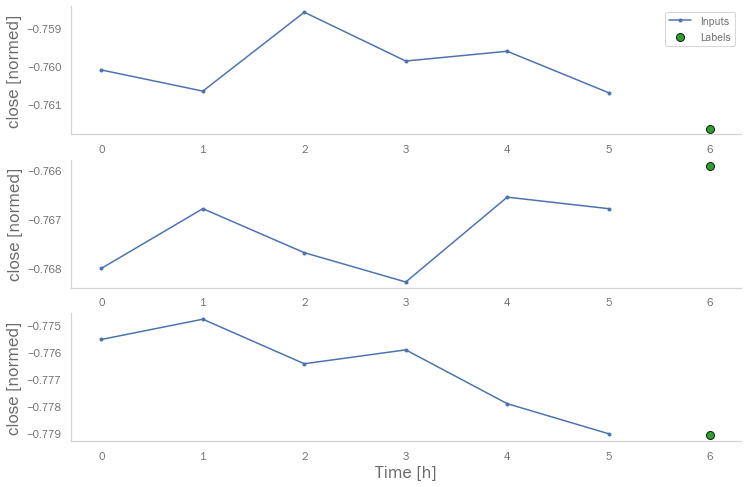

In [7]:
w2.plot()


In [8]:
@property
def train(self):
  return self.make_ds(self.train_df)

@property
def val(self):
  return self.make_ds(self.val_df)

@property
def test(self):
  return self.make_ds(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [9]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [10]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=["close"]
)
single_step_window


Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

In [11]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [12]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [13]:
column_indices = {name: i for i, name in enumerate(df.columns)}

baseline = Baseline(label_index=column_indices["close"])

baseline.compile(
    loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()]
)

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.val)
performance["Baseline"] = baseline.evaluate(single_step_window.test, verbose=0)


94/94 [==============================] - 0s 2ms/step - loss: 0.0189 - mean_absolute_error: 0.0539


In [14]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=["close"]
)

wide_window


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

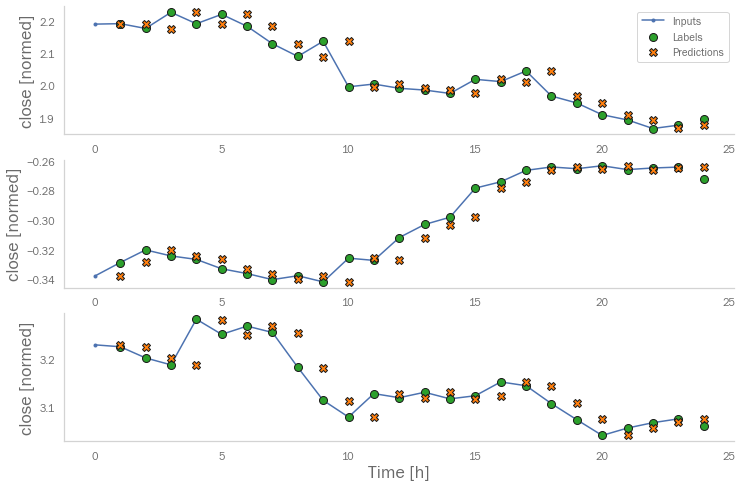

In [15]:
wide_window.plot(baseline)

In [16]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

print("Input shape:", single_step_window.example[0].shape)
print("Output shape:", linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 9)
Output shape: (32, 1, 1)


In [17]:
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )
    return history


In [18]:
history = compile_and_fit(linear, single_step_window)

val_performance["Linear"] = linear.evaluate(single_step_window.val)
performance["Linear"] = linear.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
329/329 [==============================] - 1s 1ms/step - loss: 0.1073 - mean_absolute_error: 0.2051 - val_loss: 0.0683 - val_mean_absolute_error: 0.1868
Epoch 2/20
329/329 [==============================] - 1s 2ms/step - loss: 0.0166 - mean_absolute_error: 0.0710 - val_loss: 0.0272 - val_mean_absolute_error: 0.0996
Epoch 3/20
329/329 [==============================] - 0s 1ms/step - loss: 0.0031 - mean_absolute_error: 0.0282 - val_loss: 0.0207 - val_mean_absolute_error: 0.0645
Epoch 4/20
329/329 [==============================] - 1s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0138 - val_loss: 0.0206 - val_mean_absolute_error: 0.0602
Epoch 5/20
329/329 [==============================] - 0s 1ms/step - loss: 0.0011 - mean_absolute_error: 0.0112 - val_loss: 0.0206 - val_mean_absolute_error: 0.0601
Epoch 6/20
94/94 [==============================] - 0s 602us/step - loss: 0.0206 - mean_absolute_error: 0.0601


Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


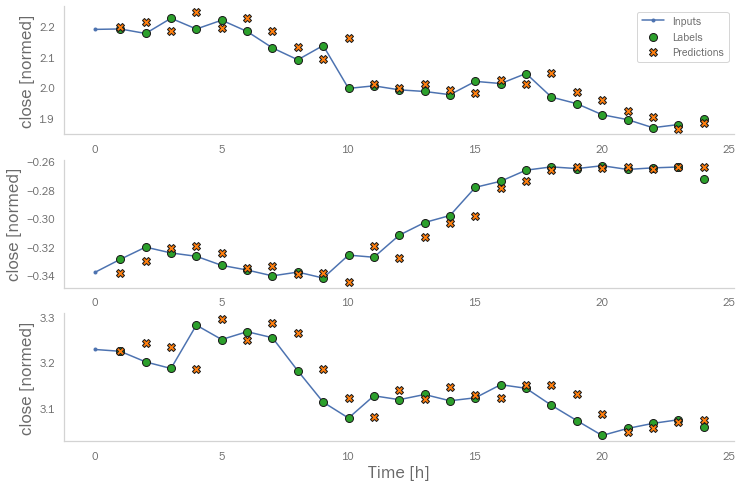

In [19]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
wide_window.plot(linear)

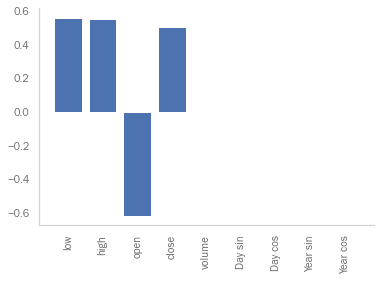

In [20]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [21]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
329/329 [==============================] - 3s 8ms/step - loss: 0.0289 - mean_absolute_error: 0.0713 - val_loss: 0.0318 - val_mean_absolute_error: 0.1184
Epoch 2/20
329/329 [==============================] - 3s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0209 - val_loss: 0.0265 - val_mean_absolute_error: 0.0968
Epoch 3/20
329/329 [==============================] - 2s 7ms/step - loss: 0.0012 - mean_absolute_error: 0.0173 - val_loss: 0.0254 - val_mean_absolute_error: 0.0922
Epoch 4/20
329/329 [==============================] - 3s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0169 - val_loss: 0.0290 - val_mean_absolute_error: 0.1056
Epoch 5/20
329/329 [==============================] - 2s 7ms/step - loss: 0.0010 - mean_absolute_error: 0.0154 - val_loss: 0.0224 - val_mean_absolute_error: 0.0799
Epoch 6/20
329/329 [==============================] - 2s 7ms/step - loss: 0.0010 - mean_absolute_error: 0.0149 - val_loss: 0.0244 - val_mean_absolute_error: 0.0899
Epoch 7/20
94/94

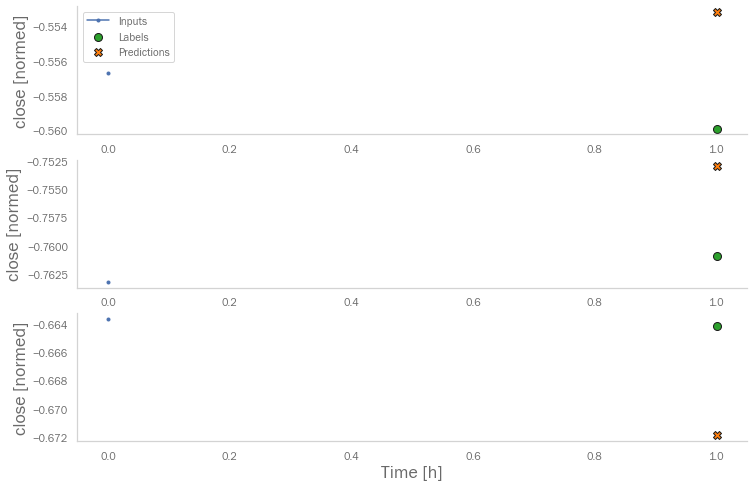

In [22]:
single_step_window.plot(dense)

In [23]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['close'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['close']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

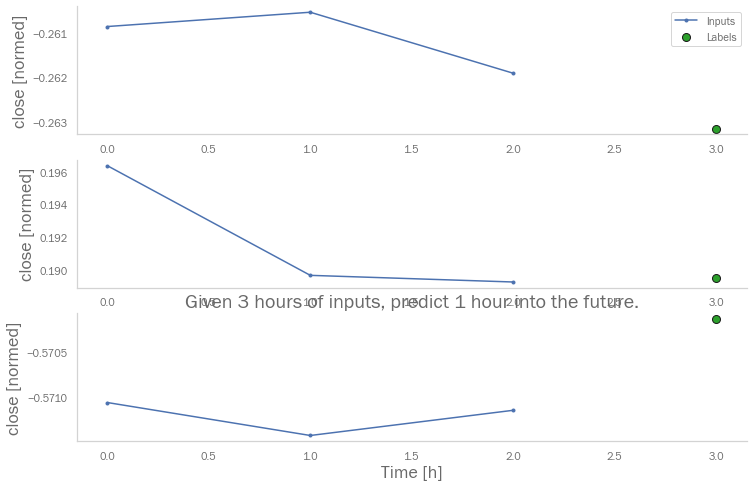

In [24]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [25]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [26]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


In [27]:
import IPython

history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance["Multi step dense"] = multi_step_dense.evaluate(conv_window.val)
performance["Multi step dense"] = multi_step_dense.evaluate(conv_window.test, verbose=0)


94/94 [==============================] - 0s 1ms/step - loss: 0.0313 - mean_absolute_error: 0.1213


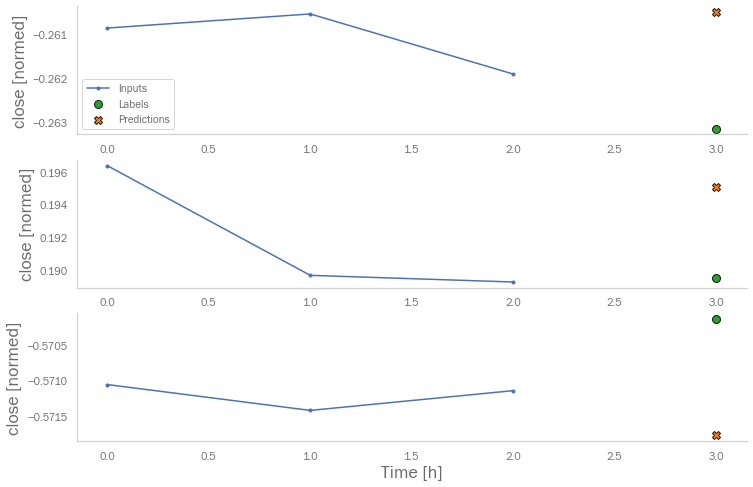

In [28]:
conv_window.plot(multi_step_dense)


In [29]:
# The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape.
print("Input shape:", wide_window.example[0].shape)
try:
    print("Output shape:", multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f"\n{type(e).__name__}:{e}")


Input shape: (32, 24, 9)

ValueError:Input 0 of layer dense_4 is incompatible with the layer: expected axis -1 of input shape to have value 27 but received input with shape (32, 216)


In [30]:
conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=(CONV_WIDTH,), activation="relu"
        ),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)


In [31]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


In [32]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

94/94 [==============================] - 0s 2ms/step - loss: 0.0323 - mean_absolute_error: 0.1144


In [42]:
day = eth.day_stats

day.plot_bokeh(``)

ValueError: No numeric data columns found for plotting.